In [4]:
import torch
import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F
import lightning
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.loggers.tensorboard import TensorBoardLogger
import utils
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
from sklearn.metrics import mean_squared_error
import os
from models import LSTMModel


In [5]:
df_train, df_test, df_valid, mu, std = utils.load_cleaned_data()

BATCH_SIZE = 32


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type    | Params
--------------------------------------
0 | lstm      | LSTM    | 1.4 K 
1 | fc        | Linear  | 68    
2 | criterion | MSELoss | 0     
--------------------------------------
1.5 K     Trainable params
0         Non-trainable params
1.5 K     Total params
0.006     Total estimated model params size (MB)


LSTM-seq_len=50 hidden_size=16 num_layer=1


Mean Squared Error: 15.246385
Root Mean Squared Error: 3.904662


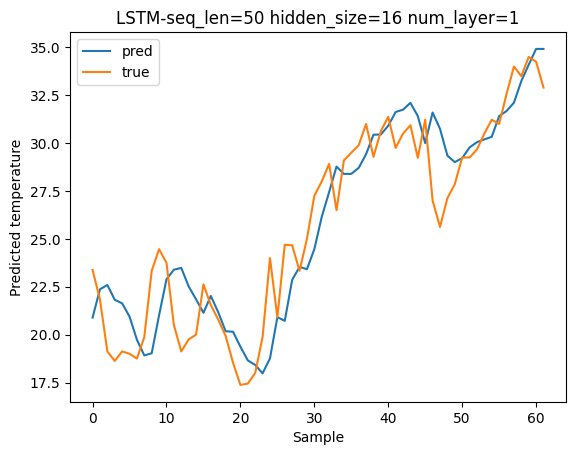

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type    | Params
--------------------------------------
0 | lstm      | LSTM    | 4.9 K 
1 | fc        | Linear  | 132   
2 | criterion | MSELoss | 0     
--------------------------------------
5.0 K     Trainable params
0         Non-trainable params
5.0 K     Total params
0.020     Total estimated model params size (MB)


LSTM-seq_len=50 hidden_size=32 num_layer=1


Mean Squared Error: 15.032557
Root Mean Squared Error: 3.8771842


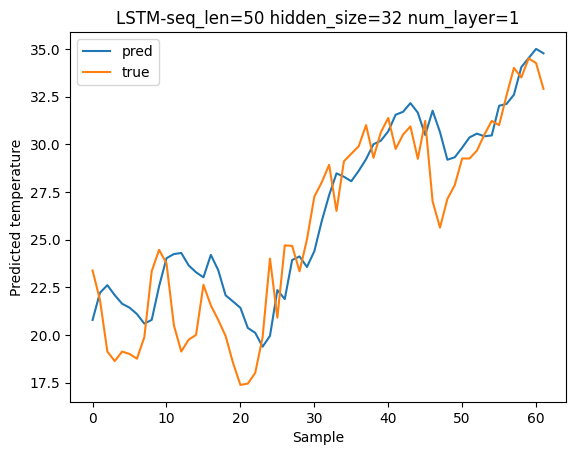

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type    | Params
--------------------------------------
0 | lstm      | LSTM    | 1.4 K 
1 | fc        | Linear  | 68    
2 | criterion | MSELoss | 0     
--------------------------------------
1.5 K     Trainable params
0         Non-trainable params
1.5 K     Total params
0.006     Total estimated model params size (MB)


LSTM-seq_len=100 hidden_size=16 num_layer=1


Mean Squared Error: 14.68454
Root Mean Squared Error: 3.8320413


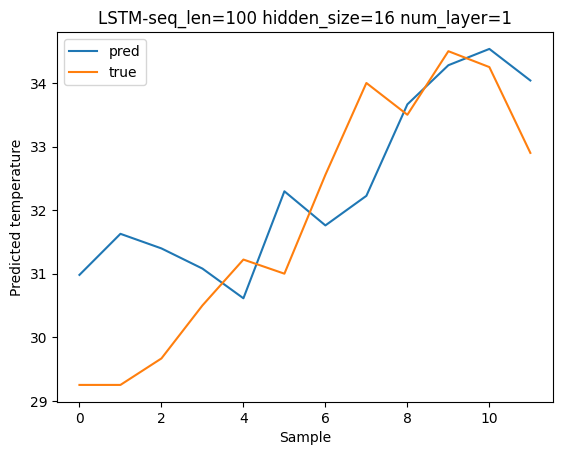

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type    | Params
--------------------------------------
0 | lstm      | LSTM    | 4.9 K 
1 | fc        | Linear  | 132   
2 | criterion | MSELoss | 0     
--------------------------------------
5.0 K     Trainable params
0         Non-trainable params
5.0 K     Total params
0.020     Total estimated model params size (MB)


LSTM-seq_len=100 hidden_size=32 num_layer=1


Mean Squared Error: 14.672573
Root Mean Squared Error: 3.8304794


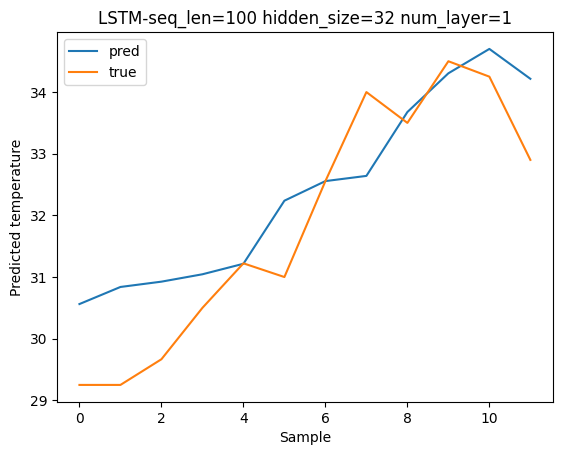

In [7]:
hidden_sizes = [8, 16, 32]
num_layers = [1, 3]
seq_lengths = [10, 20, 50, 100]

mses = []
params = []

folder = "lstm-report"

# Create folder if it does not exist
if not os.path.exists(folder):
    os.makedirs(folder)

stats_path = f"{folder}/stats.csv"

with open(stats_path, 'w') as stats_file:
    stats_file.write("Sequence_length;Hidden_size;Num_layers;MSE;RMSE\n")

for seq_len, hidden_size, num_layer in product(seq_lengths, hidden_sizes, num_layers):
    dataloader_train = torch.utils.data.DataLoader(utils.ClimateDataset(df_train, seq_len), batch_size=BATCH_SIZE, shuffle=False, num_workers=15)
    dataloader_valid = torch.utils.data.DataLoader(utils.ClimateDataset(df_valid, seq_len), batch_size=BATCH_SIZE, shuffle=False, num_workers=15)
    k = len(dataloader_train) // BATCH_SIZE

    model_name = f"LSTM-seq_len={seq_len} hidden_size={hidden_size} num_layer={num_layer}"
    print(model_name)
    model = LSTMModel(input_size=4, output_size=4, hidden_size=hidden_size, num_layers=num_layer, learning_rate=0.001)

    trainer = lightning.Trainer(
        accelerator="gpu",
        max_epochs=150,
        log_every_n_steps=k,
        callbacks=[
            EarlyStopping(monitor="val_loss", mode="min", patience=10, min_delta=0.01),
        ],
        logger=TensorBoardLogger("lstm-logs", name="", version=model_name)
    )

    trainer.fit(model, dataloader_train, dataloader_valid)

    dataloader_test = torch.utils.data.DataLoader(utils.ClimateDataset(df_test, seq_len), batch_size=1, shuffle=False, num_workers=15)
    preds, true = model.predict(dataloader_test)
    preds = preds * std.to_numpy() + mu.to_numpy()
    true = true * std.to_numpy() + mu.to_numpy()

    true = true.reshape(true.shape[0], true.shape[-1])
    preds = preds.reshape(preds.shape[0], preds.shape[-1])
    
    mse = mean_squared_error(true, preds)
    print("Mean Squared Error:", mse)
    print("Root Mean Squared Error:", np.sqrt(mse))
    plt.plot(preds[:,0], label="pred")
    plt.plot(true[:,0], label="true")
    plt.xlabel('Sample')
    plt.ylabel('Predicted temperature')
    plt.legend()
    plt.title(model_name)
    plt.savefig(f"{folder}/{model_name}.png")
    plt.show()

    with open(stats_path, 'a') as stats_file:
        stats_file.write(f"{seq_len};{hidden_size};{num_layer};{mse};{np.sqrt(mse)}\n")

    mses.append(mse)
    params.append((seq_len, hidden_size, num_layer))
